##1.0 - CARREGAMENTO DAS BIBLIOTECAS

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
import patsy as pt
from google.colab import drive
from sklearn import metrics
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1.1 Lêr arquivo

In [3]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
df = pd.read_parquet('/content/gdrive/MyDrive/Colab Notebooks/licitacao/Dados externos/sample_propostas', engine='pyarrow')

In [5]:
df.head(2)

,data,marca,valor_unitario,valor_total,Código,sub_cod_item,Categoria,Subcategoria,Descrição,Observação,Valor estimado,Quantidade,Tipo Cotacao,Data de Abertura,Data de Encerramento,Unidade Executora,Tipo de Entrega,Prazo de Entrega,Condição de Pgto,flag_vencedor,unidade_fornecimento,cnpj_hash,num_processo_hash
0,02/01/2013 - 10:21:03,JORNAL DIÁRIO DA MANHÃ,R$17.90,"R$21,480.00",3292,1,SERVICOS GERAIS,SERVIÇOS GERAIS,Serviços de publicação de matéria oficial em j...,,R$24.74,1200,Valor Unitário,02/01/2013 09:00,15/01/2013 10:05,Secretaria do Meio Ambiente e dos Recursos Híd...,Parcelada,Imediato,30 dias após a entrega,0,cm x coluna,400ca66d5ca1f98ee977ee9bb78f9429484b8eca,02ff76067be29a3a43b46688ba7603d898955281
1,02/01/2013 - 10:16:40,JORNAL O HOJE,R$18.00,"R$21,600.00",3292,1,SERVICOS GERAIS,SERVIÇOS GERAIS,Serviços de publicação de matéria oficial em j...,,R$24.74,1200,Valor Unitário,02/01/2013 09:00,15/01/2013 10:05,Secretaria do Meio Ambiente e dos Recursos Híd...,Parcelada,Imediato,30 dias após a entrega,1,cm x coluna,474a98142da4db24e9fd543aba481e2358c11868,02ff76067be29a3a43b46688ba7603d898955281


In [6]:
df['Descrição'].unique()

array(['Serviços de publicação de matéria oficial em jornal.',
       'CONSULTORIA TÉCNICA de apoio à gestão, organização, execução\r\n',
       'Licença de uso de software', ...,
       'Sifão p/pia 1.1/2 x2 PVC cromado-instalações hidro-sanitárias',
       'TÊ SOLDÁVEL C/ ROSCA NA BOLSA CENTRAL - 32mm x 3/4 polegada.',
       'Tubo pvc esgoto =40 mm (barra 6,0m)'], dtype=object)

##2 configurando os dados

In [7]:
df.dtypes

data                    object
marca                   object
valor_unitario          object
valor_total             object
Código                  object
sub_cod_item             int64
Categoria               object
Subcategoria            object
Descrição               object
Observação              object
Valor estimado          object
Quantidade              object
Tipo Cotacao            object
Data de Abertura        object
Data de Encerramento    object
Unidade Executora       object
Tipo de Entrega         object
Prazo de Entrega        object
Condição de Pgto        object
flag_vencedor            int32
unidade_fornecimento    object
cnpj_hash               object
num_processo_hash       object
dtype: object

2.1 Excluir as colunas que não são necessárias

In [8]:
# Excluir 'data', pois vamos trabalhar com datas de encerramento;
# Excluir marca que não influencia no valor, pois de acordo com a lei da licitação o similar, seguindo o padrão é valido;
# Excluir data de abertura, pois usaremos a de encerramento como parametro; 
# Excluir prazo de entrega pois o preço é balizado no momento do lance, não sendo influenciado pelo prazo, para ter o melhor lance.
# Excluir Tipo Cotacao, só existe um que é Valor Unitário
# Excluir observações instruções especifica do que esta na licitação,
# Excluir Descrição, item de refoço com especificação tecnica, de produto.
# Excluir valor total, pois o valor estimado que foi o lance vencedor.
# Excluir Código, não influencia no valor do lance;
# Excluir sub_cod_item, Não influencia no valor do lance.
dfSel = df.drop(columns= ['data', 'marca', 'Tipo Cotacao', 'Data de Abertura', 'Prazo de Entrega', 'Descrição', 'Observação', 'valor_total', 'Código', 'sub_cod_item' ])

In [9]:
dfSel.head(1)

,valor_unitario,Categoria,Subcategoria,Valor estimado,Quantidade,Data de Encerramento,Unidade Executora,Tipo de Entrega,Condição de Pgto,flag_vencedor,unidade_fornecimento,cnpj_hash,num_processo_hash
0,R$17.90,SERVICOS GERAIS,SERVIÇOS GERAIS,R$24.74,1200,15/01/2013 10:05,Secretaria do Meio Ambiente e dos Recursos Híd...,Parcelada,30 dias após a entrega,0,cm x coluna,400ca66d5ca1f98ee977ee9bb78f9429484b8eca,02ff76067be29a3a43b46688ba7603d898955281


In [10]:
dfSel.dtypes

valor_unitario          object
Categoria               object
Subcategoria            object
Valor estimado          object
Quantidade              object
Data de Encerramento    object
Unidade Executora       object
Tipo de Entrega         object
Condição de Pgto        object
flag_vencedor            int32
unidade_fornecimento    object
cnpj_hash               object
num_processo_hash       object
dtype: object

In [11]:
#Retirando o R$ e transformando em float o valor_unitario
dfSel['valor_unitario'] = dfSel['valor_unitario'].map(lambda x: x.lstrip('R').rstrip('$'))
dfSel['valor_unitario'] = dfSel['valor_unitario'].map(lambda x: x.lstrip('$'))
dfSel['valor_unitario'] = dfSel['valor_unitario'].apply(lambda x: str(x).replace(',',''))
dfSel['valor_unitario'] = dfSel['valor_unitario'].astype('float64')

In [12]:
#Retirando o R$ e transformando em float o Valor estimado
dfSel['Valor estimado'] = dfSel['Valor estimado'].map(lambda x: x.lstrip('R').rstrip('$'))
dfSel['Valor estimado'] = dfSel['Valor estimado'].map(lambda x: x.lstrip('$'))
dfSel['Valor estimado'] = dfSel['Valor estimado'].apply(lambda x: str(x).replace(',',''))
dfSel['Valor estimado'] = dfSel['Valor estimado'].astype('float64')

In [13]:
#tirar os caracteres para transformar em int ou float
dfSel['Condição de Pgto'] = dfSel['Condição de Pgto'].apply(lambda x: x.strip('dias após a entrega'))
dfSel['Condição de Pgto']= dfSel['Condição de Pgto'].replace(['À v'],['0'])
dfSel['Condição de Pgto']= dfSel['Condição de Pgto'].fillna(0)
dfSel['Quantidade'] = dfSel['Quantidade'].apply(lambda x: x.strip(''))

In [14]:
dfSel.head(2)

,valor_unitario,Categoria,Subcategoria,Valor estimado,Quantidade,Data de Encerramento,Unidade Executora,Tipo de Entrega,Condição de Pgto,flag_vencedor,unidade_fornecimento,cnpj_hash,num_processo_hash
0,17.9,SERVICOS GERAIS,SERVIÇOS GERAIS,24.74,1200,15/01/2013 10:05,Secretaria do Meio Ambiente e dos Recursos Híd...,Parcelada,30,0,cm x coluna,400ca66d5ca1f98ee977ee9bb78f9429484b8eca,02ff76067be29a3a43b46688ba7603d898955281
1,18.0,SERVICOS GERAIS,SERVIÇOS GERAIS,24.74,1200,15/01/2013 10:05,Secretaria do Meio Ambiente e dos Recursos Híd...,Parcelada,30,1,cm x coluna,474a98142da4db24e9fd543aba481e2358c11868,02ff76067be29a3a43b46688ba7603d898955281


In [15]:
dfSel.dtypes

valor_unitario          float64
Categoria                object
Subcategoria             object
Valor estimado          float64
Quantidade               object
Data de Encerramento     object
Unidade Executora        object
Tipo de Entrega          object
Condição de Pgto         object
flag_vencedor             int32
unidade_fornecimento     object
cnpj_hash                object
num_processo_hash        object
dtype: object

In [16]:
dfSel.head(2)

,valor_unitario,Categoria,Subcategoria,Valor estimado,Quantidade,Data de Encerramento,Unidade Executora,Tipo de Entrega,Condição de Pgto,flag_vencedor,unidade_fornecimento,cnpj_hash,num_processo_hash
0,17.9,SERVICOS GERAIS,SERVIÇOS GERAIS,24.74,1200,15/01/2013 10:05,Secretaria do Meio Ambiente e dos Recursos Híd...,Parcelada,30,0,cm x coluna,400ca66d5ca1f98ee977ee9bb78f9429484b8eca,02ff76067be29a3a43b46688ba7603d898955281
1,18.0,SERVICOS GERAIS,SERVIÇOS GERAIS,24.74,1200,15/01/2013 10:05,Secretaria do Meio Ambiente e dos Recursos Híd...,Parcelada,30,1,cm x coluna,474a98142da4db24e9fd543aba481e2358c11868,02ff76067be29a3a43b46688ba7603d898955281


In [17]:
#Transformar todas variaveis continuas em float ou int 
dfSel['Condição de Pgto'] = dfSel['Condição de Pgto'].astype(int)
dfSel['flag_vencedor'] = dfSel['flag_vencedor'].astype(bool)
dfSel['Quantidade'] = dfSel['Quantidade'].replace(',', '').astype(float)

In [18]:
#trnsformar a data
dfSel['Data de Encerramento'] = pd.to_datetime(dfSel['Data de Encerramento'])

In [19]:
dfSel.head(2)


,valor_unitario,Categoria,Subcategoria,Valor estimado,Quantidade,Data de Encerramento,Unidade Executora,Tipo de Entrega,Condição de Pgto,flag_vencedor,unidade_fornecimento,cnpj_hash,num_processo_hash
0,17.9,SERVICOS GERAIS,SERVIÇOS GERAIS,24.74,1200.0,2013-01-15 10:05:00,Secretaria do Meio Ambiente e dos Recursos Híd...,Parcelada,30,False,cm x coluna,400ca66d5ca1f98ee977ee9bb78f9429484b8eca,02ff76067be29a3a43b46688ba7603d898955281
1,18.0,SERVICOS GERAIS,SERVIÇOS GERAIS,24.74,1200.0,2013-01-15 10:05:00,Secretaria do Meio Ambiente e dos Recursos Híd...,Parcelada,30,True,cm x coluna,474a98142da4db24e9fd543aba481e2358c11868,02ff76067be29a3a43b46688ba7603d898955281


In [20]:
dfSel.shape

(1482377, 13)

In [21]:
#Transformar data frame booleano em 1 e 0
def bool2int(df):
    bool_cols = df.select_dtypes('bool').columns
    for col in bool_cols:
        df[col] = df[col].map(lambda x: 1 if x is True else 0)
    return df

In [22]:
dfSel = bool2int(dfSel)

In [23]:
#Simplificando o nome das colunas
dfSel.rename(columns={'Data de Encerramento' : 'Data',
                      'Valor estimado': 'valorEstimado',
                      'valor_unitario': 'valorUn',
                      'Tipo de Entrega':'entrega',
                      'Condição de Pgto':'pagamento'
                      }, inplace=True)

In [49]:
# Selecionando o periodo evitar variancia myuito grande de preço visto a questão da infração.
df21 = dfSel[dfSel['Data'] >= '2013-01-01']
df21.shape

(1482377, 13)

In [50]:
df21['Subcategoria'].value_counts()

SERVIÇOS GERAIS                                                 87198
ARTIGOS PARA ESCRITÓRIO                                         80528
EQUIPAMENTOS E ARTIGOS DE LABORATÓRIO                           77192
FRUTAS, VERDURAS E LEGUMES                                      57071
PRODUTOS ALIMENTÍCIOS;  PANIFICAÇÃO E CEREAIS  ( DIVERSOS )     56389
                                                                ...  
MINÉRIOS                                                            3
ARMAS DE CALIBRE ATÉ 30 MM                                          2
EQUIPAMENTO DE CAMUFLAGEM E DE DISSIMULAÇÃO                         2
HÉLICES DE AERONAVES S SEUS COMPONENTES                             1
EQUIPAMENTO PARA ABASTECIMENTO DE COMBUSTÍVEL E LUBRIFICAÇÃO        1
Name: Subcategoria, Length: 349, dtype: int64

In [51]:
g = df21.groupby(['Categoria', 'Subcategoria']).mean()

In [52]:
g.head(2)

valorUn  ...  flag_vencedor
Categoria             Subcategoria                                                       ...               
ACESSORIOS DE MOTORES ACESSORIOS DIVERSOS DE MOTORES DE AERONAVES         392518.632545  ...       0.272727
                      ACESSÓRIOS DIVERSOS DE MOTORES, EXCETO OS DE AE...    3413.379600  ...       0.152000

[2 rows x 5 columns]

In [53]:
#filtrar por categoria e subcategoria
dfFilter = df21[(df21['Categoria'] == 'ACESSORIOS DE MOTORES') & (df21['Subcategoria'] == 'ACESSORIOS DIVERSOS DE MOTORES DE AERONAVES')]
dfFilter.shape

(55, 13)

In [54]:
dfFilter.describe()

,valorUn,valorEstimado,Quantidade,pagamento,flag_vencedor
count,5.500000e+01,5.500000e+01,55.0,55.000000,55.000000
mean,3.925186e+05,4.315657e+05,1.0,29.454545,0.272727
std,5.598423e+05,6.033224e+05,0.0,4.045199,0.449467
min,7.170000e+03,7.800000e+03,1.0,0.000000,0.000000
25%,4.000000e+04,4.000000e+04,1.0,30.000000,0.000000
50%,9.600000e+04,9.600000e+04,1.0,30.000000,0.000000
75%,7.568277e+05,7.568702e+05,1.0,30.000000,1.000000
max,2.050787e+06,2.050787e+06,1.0,30.000000,1.000000


In [55]:
contColNames = dfFilter.select_dtypes(include='number').columns

In [56]:
ncols=3

In [57]:
nrows = int(np.ceil(len(contColNames)/(1.0*ncols)))

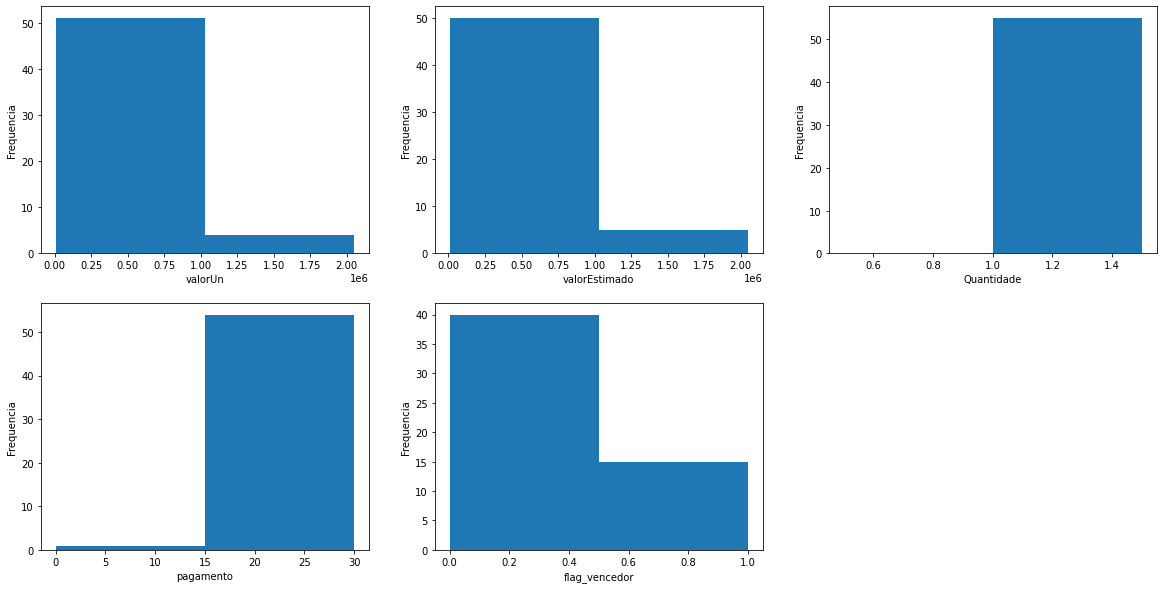

In [58]:
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize = (20,10)) 

counter = 0

for i in range(nrows):
  for j in range(ncols):

    ax = axes[i][j]

    #Plotar somente qiuando houver dados

    if counter < len(contColNames):

      ax.hist(dfFilter[contColNames[counter]], bins=2)
      ax.set_xlabel(contColNames[counter])
      ax.set_ylabel('Frequencia')

    else:
      ax.set_axis_off()
    
    counter += 1

plt.show()

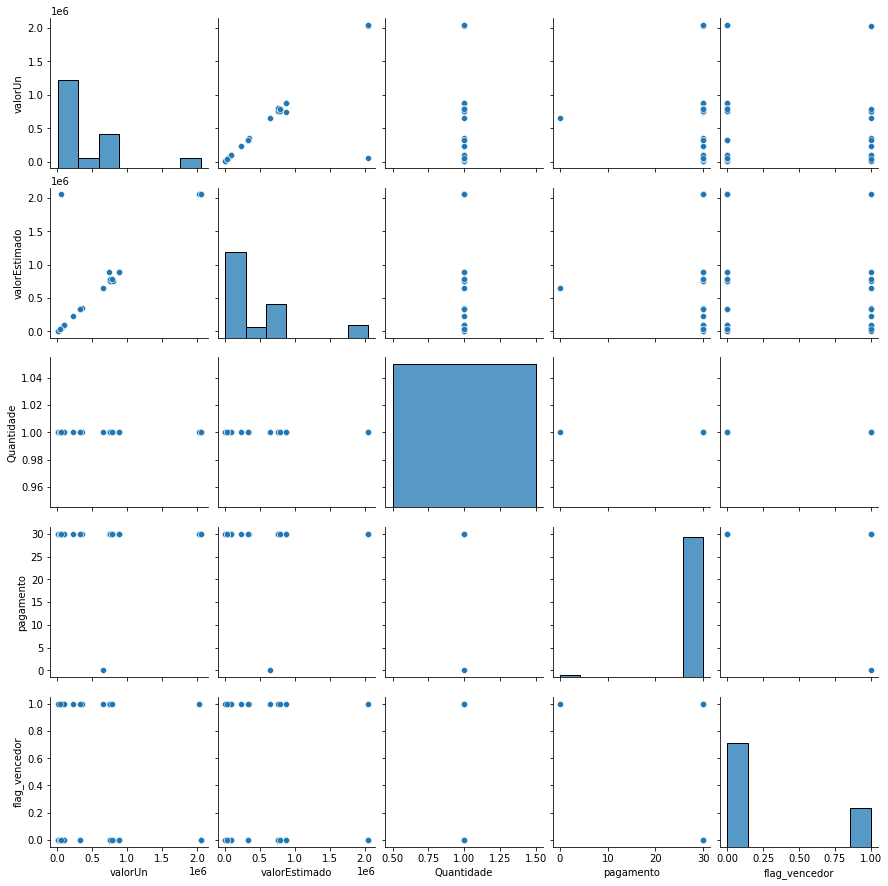

In [59]:
#Teste de correlação
sns.pairplot(dfFilter)


In [43]:
dfFilter.corr()

,valorUn,valorEstimado,Quantidade,pagamento,flag_vencedor
valorUn,1.000000,-0.035886,0.048567,-0.108990,-0.034080
valorEstimado,-0.035886,1.000000,-0.482776,-0.093627,0.197497
Quantidade,0.048567,-0.482776,1.000000,0.114636,-0.182462
pagamento,-0.108990,-0.093627,0.114636,1.000000,0.025113
flag_vencedor,-0.034080,0.197497,-0.182462,0.025113,1.000000
